In [79]:
# import sys  
# !{sys.executable} -m pip install --user pandas scikit_learn seaborn
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import RandomizedSearchCV
from matplotlib.patches import Ellipse
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np

pd.options.mode.chained_assignment = None

data = pd.read_csv("train.csv")
data2 = pd.read_csv("test.csv")

C:\Users\gidro\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Доля правильных ответов классификатора на обучающей выборке: 0.679
{'C': 2.195254015709299}


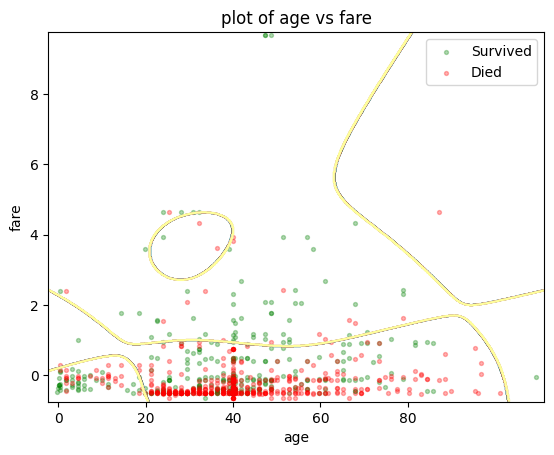

In [114]:
label_encoder = LabelEncoder()
scaler = StandardScaler()
onehotencoder = OneHotEncoder(sparse_output=False)

data[['died', 'survived']] = onehotencoder.fit_transform(data['Survived'].values.reshape(-1, 1))
data[['firstclass','secondclass', 'thirdclass']] = onehotencoder.fit_transform(data['Pclass'].values.reshape(-1,1))
data['Sex'] = label_encoder.fit_transform(data['Sex'])
data[['male','female']] = onehotencoder.fit_transform(data['Sex'].values.reshape(-1,1))
data[['southampton', 'cherbourg', 'queenstown', 'N/A']] = onehotencoder.fit_transform(data['Embarked'].values.reshape(-1,1))
data['age'] = scaler.fit_transform(data['Age'].values.reshape(-1,1))
data['sibsp'] = scaler.fit_transform(data['SibSp'].values.reshape(-1, 1))
data['parch'] = scaler.fit_transform(data['Parch'].values.reshape(-1, 1))
data['fare'] = scaler.fit_transform(data['Fare'].values.reshape(-1, 1))

df = data.drop(columns = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'survived', 'died', 'firstclass', 'secondclass', 'thirdclass',
       'male', 'female', 'southampton', 'cherbourg', 'queenstown', 'N/A', 'sibsp', 'parch'])

i = 0
for age in df["age"]:
    if np.isnan(age):
        df["age"][i] = 0
    i+=1

cols = df.columns.tolist()
cols = cols[1:] + cols[:1]
df = df[cols]

X = df.iloc[:, :2].values
Y = df.iloc[:, 2].values
plt.scatter(X[Y == 1, 0], X[Y == 1,1], c='green', label='Survived', s=8, alpha=0.3)
plt.scatter(X[Y == 0,0], X[Y == 0,1], c='red', label='Died', s=8, alpha=0.3)

def plot_boundary(clf, X, Y, grid_step=.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
    np.arange(y_min, y_max, grid_step))
    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X)
C = 2.51
logit = LogisticRegression(C=C, n_jobs=1, random_state=10)
logit.fit(X_poly, Y)

plot_boundary(logit, X, Y, grid_step=.01, poly_featurizer=poly)
plt.xlabel("age")
plt.ylabel("fare")
plt.xticks([-2, -1, 0, 1, 2], labels=['0', '20', '40', '60', '80'])    
plt.title('plot of age vs fare')
plt.legend()

print("Доля правильных ответов классификатора на обучающей выборке:", 
round(logit.score(X_poly, Y), 3))

distributions=dict(C=stats.uniform(loc=0, scale=4))
logistic = LogisticRegression(C=C, n_jobs=1, random_state=10)
clf = RandomizedSearchCV(logistic, distributions, random_state=0)
search = clf.fit(X, Y)
print(search.best_params_)


0.6853932584269663
{'n_neighbors': 15}


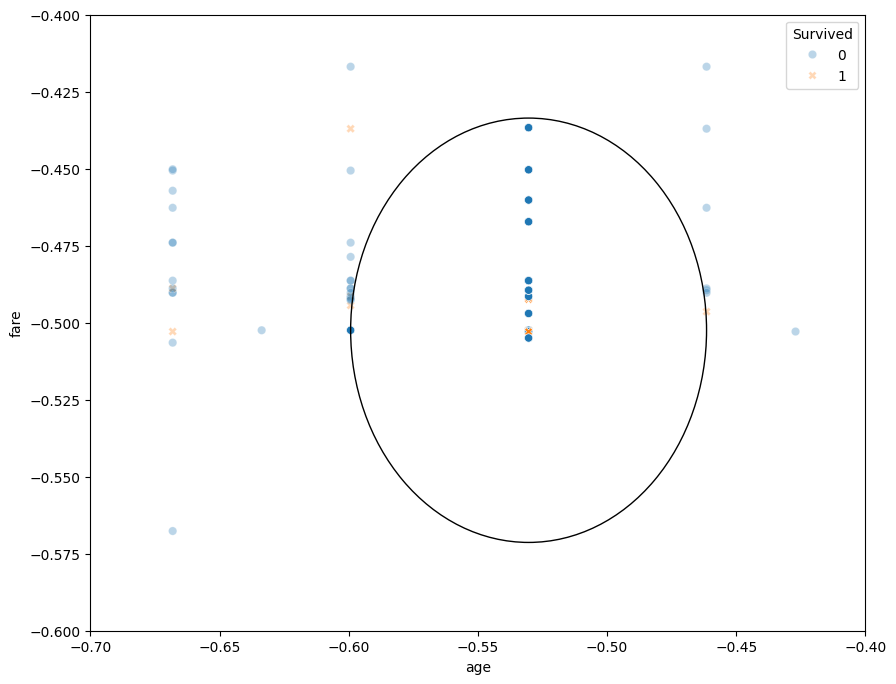

In [166]:
predictors = ['age', 'fare'] 
outcome = 'Survived' 

new_record = df.loc[0:0, predictors] 
X = df.loc[1:, predictors] 
y = df.loc[1:, outcome] 

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
knn.predict(new_record)

nbrs = knn.kneighbors(new_record)
nbr_df = pd.DataFrame({'age': X.iloc[nbrs[1][0], 0], 
                         'fare': X.iloc[nbrs[1][0], 1],
                         'Survived': y.iloc[nbrs[1][0]]})

maxDistance = np.max(nbrs[0][0])

fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(x = 'age', y = 'fare', style = 'Survived', 
                hue='Survived', data=df, alpha=0.3, ax=ax)
sns.scatterplot(x = 'age', y = 'fare', style = 'Survived', 
                hue = 'Survived', 
                data = pd.concat([df.loc[0:0, :], df.loc[nbrs[1][0] + 1,:]]), 
                ax = ax, legend=False)
ellipse = Ellipse(xy = new_record.values[0], 
                  width = 2 * maxDistance, height = 2 * maxDistance,
                  edgecolor = 'black', fc = 'None', lw = 1)
ax.add_patch(ellipse)

ax.set_xlim(-0.7, -0.4)
ax.set_ylim(-0.6, -0.4)

nbrs = knn.kneighbors(new_record)
nbr_df = pd.DataFrame({'Age': X.iloc[nbrs[1][0], 0], 
                         'Fare': X.iloc[nbrs[1][0], 1],
                         'Survived': y.iloc[nbrs[1][0]]})

k_range=list(range(0,490))
param_grid=dict(n_neighbors=k_range)
 
KNNClassifierModel = KNeighborsClassifier(n_neighbors= 5)

clf = RandomizedSearchCV(KNNClassifierModel, param_grid, scoring='accuracy', n_iter = 10, random_state=0)
search = clf.fit(X, y)
print(search.best_score_)
print(search.best_params_)